# Medicines recommendation Model
The model utilizes natural language processing techniques, leveraging the NLTK library, to analyze the description of the patient's symptoms and conditions. Based on this analysis, it recommends the most appropriate medication. Additionally, the model refines its recommendations by considering the ratings of the medication manufacturers, ensuring that the suggested medications come from reputable sources.

# Import all necessary libraries

In [11]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

from flask import Flask, request, jsonify,render_template

In [4]:
import warnings
warnings.filterwarnings("ignore")

    # Import NLTK packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Load Datasets and Data Preprocessing

In [6]:
df1= pd.read_csv("C:\\Users\\HP\\Downloads\\Medicine_dataset\\Company_Name.csv")
df1.sample(3)

,S.No,Company_Name,NSE_Symbol,Rating,Industry,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
6968,6969,JB Chemicals & Pharmaceuticals Ltd.,JBCHEPHARM,JB,Pharmaceuticals & Drugs,NaN,NaN,NaN,NaN
22461,22462,Alkem Laboratories Ltd.,ALKEM,AL,Pharmaceuticals & Drugs,NaN,NaN,NaN,NaN
4935,4936,Sun Pharmaceutical Industries Ltd.,SUNPHARMA,S,Pharmaceuticals & Drugs,NaN,NaN,NaN,NaN


In [7]:
# Create a dictionary mapping letters to their corresponding values
rating_mapping = {
    'S': 4.8,
    'R': 4.7,
    'D': 4.5,
    'C': 4.3,
    'B': 4.1,
    'AU': 3.9,
    'T': 3.5,
    'L': 3.4,
    'CA': 3.3,
    'ABB': 3.25,
    'AL': 3.2,
    'G': 3.1,
    'I': 3,
    'ALEM': 2.9,
    'GL': 2.7,
    'JB': 2.5
}

# Replace the values in the 'rating' column using the mapping
df1['Rating'] = df1['Rating'].replace(rating_mapping)
df1.drop(columns=['Industry','Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8'], inplace=True)

df1.sample(5)


,S.No,Company_Name,NSE_Symbol,Rating
3641,3642,Alembic Pharmaceuticals Ltd.,ALEMBIC,2.9
11855,11856,Dr. Reddys Laboratories Ltd.,DRREDDY,4.7
11170,11171,Aurobindo Pharma Ltd.,AUROPHARMA,3.9
13346,13347,Sun Pharmaceutical Industries Ltd.,SUNPHARMA,4.8
15325,15326,Torrent Pharmaceuticals Ltd.,TORNTPHARM,3.5


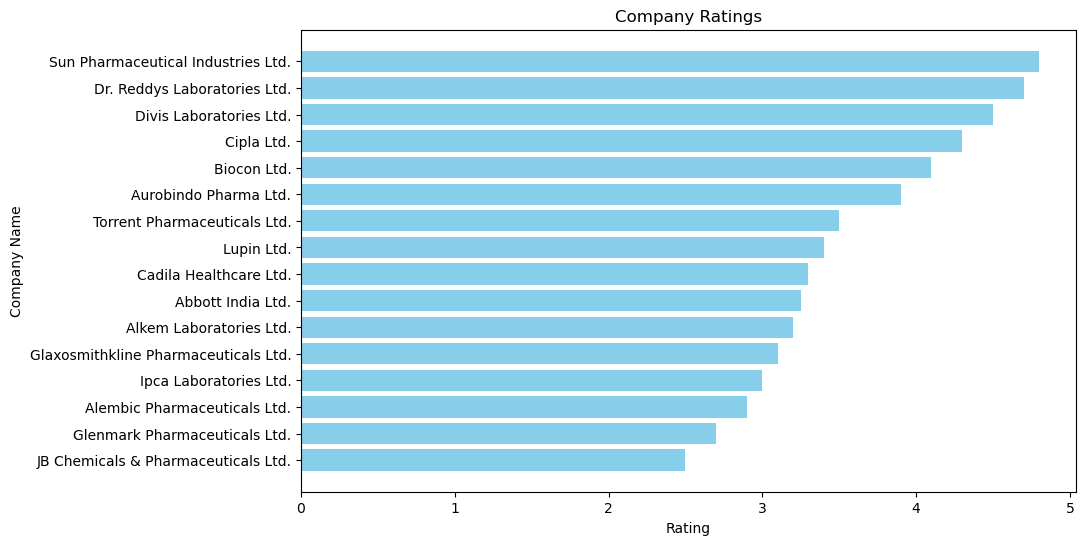

In [12]:
unique_companies = df1[['Company_Name', 'Rating']].drop_duplicates()

sorted_data = unique_companies.sort_values(by='Rating', ascending=False)

# Extract company names and ratings after sorting
company_names = sorted_data['Company_Name'].tolist()
ratings = sorted_data['Rating'].tolist()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.barh(company_names, ratings, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Company Name')
plt.title('Company Ratings')
plt.gca().invert_yaxis() 
plt.show()

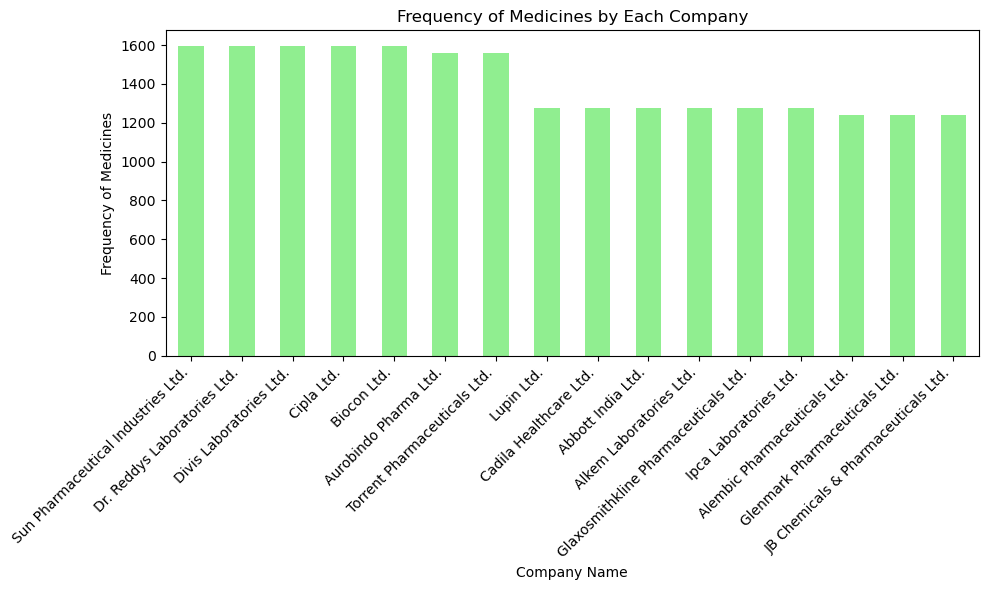

In [17]:
medicine_frequency = df1['Company_Name'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
medicine_frequency.plot(kind='bar', color='lightgreen')
plt.xlabel('Company Name')
plt.ylabel('Frequency of Medicines')
plt.title('Frequency of Medicines by Each Company')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

In [6]:
df2 = pd.read_csv("C:\\Users\\HP\\Downloads\\Medicine_dataset\\Medicine_description.csv")
df2.head()

,Drug_Name,Reason,Description
0,A CN Gel(Topical) 20gmA CN Soap 75gm,Acne,Mild to moderate acne (spots)
1,A Ret 0.05% Gel 20gmA Ret 0.1% Gel 20gmA Ret 0...,Acne,A RET 0.025% is a prescription medicine that i...
2,ACGEL CL NANO Gel 15gm,Acne,It is used to treat acne vulgaris in people 12...
3,ACGEL NANO Gel 15gm,Acne,It is used to treat acne vulgaris in people 12...
4,Acleen 1% Lotion 25ml,Acne,treat the most severe form of acne (nodular ac...


In [7]:
df2['Description'] = df2['Description'].str.lower()


In [8]:
data = pd.concat([df1, df2], axis=1)
data.head()

,S.No,Company_Name,NSE_Symbol,Rating,Drug_Name,Reason,Description
0,1,Sun Pharmaceutical Industries Ltd.,SUNPHARMA,4.8,A CN Gel(Topical) 20gmA CN Soap 75gm,Acne,mild to moderate acne (spots)
1,2,Dr. Reddys Laboratories Ltd.,DRREDDY,4.7,A Ret 0.05% Gel 20gmA Ret 0.1% Gel 20gmA Ret 0...,Acne,a ret 0.025% is a prescription medicine that i...
2,3,Divis Laboratories Ltd.,DIVISLAB,4.5,ACGEL CL NANO Gel 15gm,Acne,it is used to treat acne vulgaris in people 12...
3,4,Cipla Ltd.,CIPLA,4.3,ACGEL NANO Gel 15gm,Acne,it is used to treat acne vulgaris in people 12...
4,5,Biocon Ltd.,BIOCON,4.1,Acleen 1% Lotion 25ml,Acne,treat the most severe form of acne (nodular ac...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   S.No          22481 non-null  int64  
 1   Company_Name  22481 non-null  object 
 2   NSE_Symbol    22481 non-null  object 
 3   Rating        22481 non-null  float64
 4   Drug_Name     22481 non-null  object 
 5   Reason        22481 non-null  object 
 6   Description   22481 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.2+ MB


In [10]:
data.isnull().sum()

S.No            0
Company_Name    0
NSE_Symbol      0
Rating          0
Drug_Name       0
Reason          0
Description     0
dtype: int64

In [11]:
unique_entries = data['Reason'].unique()
print(unique_entries)

['Acne' 'Adhd' 'Allergies' 'Alzheimer' 'Amoebiasis' 'Anaemia' 'Angina'
 'Anxiety' 'Appetite' 'Arrhythmiasis' 'Arthritis' 'Cleanser'
 'Constipation' 'Contraception' 'Dandruff' 'Depression' 'Diabetes'
 'Diarrhoea' 'Digestion' 'Fever' 'Fungal' 'General' 'Glaucoma' 'Gout'
 'Haematopoiesis' 'Haemorrhoid' 'Hyperpigmentation' 'Hypertension'
 'Hyperthyroidism' 'Hypnosis' 'Hypotension' 'Hypothyroidism' 'Infection'
 'Leprosy' 'Malarial' 'Migraine' 'Mydriasis' 'Osteoporosis' 'Pain'
 'Parkinson' 'Psychosis' 'Pyrexia' 'Scabies' 'Schizophrenia' 'Smoking'
 'Supplement' 'Thrombolysis' 'Vaccines' 'Vertigo' 'Viral' 'Wound']


# Text Preprcessing


The text undergoes preprocessing, which involves several steps such as removing stopwords, lemmatization, and tokenization using the NLTK library. This preprocessing enhances the quality of the text data, making it more suitable for further analysis and modeling tasks.

In [12]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
        words = word_tokenize(text)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
        lemmatized_words = [word for word in lemmatized_words if word not in string.punctuation]
        unique_lemmatized_words = list(set(lemmatized_words))
        return ' '.join(unique_lemmatized_words)

In [13]:
data['preprocessed_Description'] = data['Description'].apply(preprocess_text)

In [14]:
user_reason = input("Enter the reason: ")

# Create a new DataFrame containing only rows where the reason matches user input
new_df = data[data['Reason'] == user_reason]
new_df.reset_index(drop=True, inplace=True)

Enter the reason: Acne


In [15]:
user_input = input("Enter your description for the medicine: ")

Enter your description for the medicine: treat acne



Recommendations are generated by computing the cosine similarity scores between the user-provided description of symptoms and our dataset. This similarity measurement helps identify the most relevant matches between the user input and the available data, facilitating accurate and personalized recommendations

In [16]:
user_words = word_tokenize(user_input)
filtered_user_words = [word for word in user_words if word.lower() not in stop_words]

lemmatized_user_words = [lemmatizer.lemmatize(word) for word in filtered_user_words]
lemmatized_user_words = [word for word in lemmatized_user_words if word not in string.punctuation]
unique_lemmatized_user_words = ' '.join(list(set(lemmatized_user_words)))

vectorizer = CountVectorizer()
user_keyword_vector = vectorizer.fit_transform([unique_lemmatized_user_words])

cosine_similarity_scores = []

for row_index in range(len(new_df)):
    keyword_vector = vectorizer.transform([new_df['preprocessed_Description'][row_index]])
    cosine_similarity_score = cosine_similarity(user_keyword_vector, keyword_vector)
    cosine_similarity_scores.append(cosine_similarity_score[0][0])

cosine_similarity_df = pd.DataFrame({
    'Cosine Similarity': cosine_similarity_scores,
    'Description': new_df['Description'],
    'Drug_Name':new_df['Drug_Name'],
    'Rating':new_df['Rating'],
    'Reason':new_df['Reason']
})

cosine_similarity_df = cosine_similarity_df.sort_values(by='Cosine Similarity', ascending=False)

top_3_similarities = cosine_similarity_df.head(3)

In [17]:
top_3_similarities

,Cosine Similarity,Description,Drug_Name,Rating,Reason
197,1.0,treat the most severe form of acne (nodular ac...,Femolink Cream 20gm,3.4,Acne
329,1.0,it is used to treat acne vulgaris in people 12...,Skinbless Cream 20gm,2.9,Acne
155,1.0,treat acne vulgaris,D Acne I 20mg Capsule 10'SD Acne I 10mg Capsul...,2.9,Acne


In [18]:
top_3_similarities = top_3_similarities.sort_values(by='Rating', ascending=False)

# Print the medicine name and description in the order of highest rating
for index, row in top_3_similarities.iterrows():
    print("Medicine Name:", row['Drug_Name'])
    print("Description:", row['Description'])
    print() 


Medicine Name: Femolink Cream 20gm
Description: treat the most severe form of acne (nodular acne) 

Medicine Name: Skinbless Cream 20gm
Description: it is used to treat acne vulgaris in people 12 years of age and older. acne vulgaris is a condition in which the skin has blackheads, white heads and pimple

Medicine Name: D Acne I 20mg Capsule 10'SD Acne I 10mg Capsule 10'S
Description:  treat acne vulgaris 

